In [19]:
using Plots, ProgressMeter, CUDA, JLD2

In [20]:
E = load("Filter_matrices.jld2")
h_Eki = E["Eki"]
h_Eik = E["Eik"]
;

In [21]:
# Simulation parameters
nx=129
ny=nx
ncells=Int32(nx*ny)

iterations=50
savingperiod=1
u0 = 0.1f0
ρ0 = 1.0f0
Re = 1000.0f0
ν = (nx-1)*u0/Re # Kinematic viscosity (0.005 <= ν <= 0.2)

println("ν = ", ν)

# Directions
h_dx = [0, 1, 0, -1, 0, 1, 1, -1, -1]
h_dy = [0, 0, -1, 0, 1, 1, -1, -1, 1]
h_w = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]

h_opp = [1, 4, 5, 2, 3, 8, 9, 6, 7]

# Geometry
h_geometry=ones(Int, nx, ny)    # Wall cells
h_geometry[2:nx-1,2:ny-1] .= 0  # fluid cells
h_geometry[:,ny] .= 2           # Top lid cells

h_geom = vec(h_geometry)

# Host side distribution functions
h_fmin = zeros(Float32, 9, ncells)
h_fplus = similar(h_fmin)
h_αmin = similar(h_fmin)
h_αplus = similar(h_fmin)

# Host side saving variables
h_ρ = zeros(Float32, ncells)
h_ux = zeros(Float32, ncells)
h_uy = zeros(Float32, ncells)

# Initial distribution set at equilibrium
h_fmin[1, :] .= ρ0 * (4/9)
h_fmin[2:5, :] .= ρ0 * (1/9)
h_fmin[6:9, :] .= ρ0 * (1/36)
;

ν = 0.012800001


In [22]:
# Move data over to GPU
d_fmin = CuArray(h_fmin)
d_fplus = CuArray(h_fplus)
d_αmin = CuArray(h_αmin)
d_αplus = CuArray(h_αplus)

# Saving variables on GPU
d_ρ = CuArray(h_ρ)
d_ux  = CuArray(h_ux)
d_uy  = CuArray(h_uy)

# Precomputed arrays on GPU
d_w = CuArray(h_w)
d_dx = CuArray(Int32.(h_dx))
d_dy = CuArray(Int32.(h_dy))
d_opp = CuArray(Int32.(h_opp))
d_Eik = CuArray(h_Eik)
d_Eki = CuArray(h_Eki)
d_geom = CuArray(Int32.(h_geom))
;

In [23]:
# GPU kernels
function collision_kernel!(tid, fmin, fplus, αmin, αplus, Eki, Eik, w, ν, ncells)
    if tid < 1 || tid > ncells
        return
    end
    
    idx = tid
    for k in 1:9
        acc = 0f0
        for i in 1:9
            acc += Eki[k, i] * fmin[i, idx]
        end
        αmin[k, idx] = acc
    end

    νfactor = -6*ν - 1

    αplus[1, idx] = αmin[1, idx]
    αplus[2, idx] = αmin[2, idx]
    αplus[3, idx] = αmin[3, idx]
    αplus[4, idx] = αmin[4, idx] + 2*(αmin[4, idx] - 3*αmin[2, idx]^2/αmin[1, idx])/νfactor
    αplus[5, idx] = αmin[5, idx] + 2*(αmin[5, idx] - 3*αmin[2, idx]*αmin[3, idx]/αmin[1, idx])/νfactor
    αplus[6, idx] = αmin[6, idx] + 2*(αmin[6, idx] - 3*αmin[3, idx]^2/αmin[1, idx])/νfactor
    αplus[7, idx] = 0
    αplus[8, idx] = 0
    αplus[9, idx] = 0

    for i in 1:9
        acc = 0f0
        for k in 1:9
            acc += w[i] * Eik[i, k] * αplus[k, idx]
        end
        fplus[i, idx] = acc
    end
    
    return
end

function streaming_kernel!(tid, fmin, fplus, αplus, geom, w, nx, ny, ncells, dx, dy, opp, u0)
    if tid < 1 || tid > ncells
        return
    end

    idx = tid
    j = (idx - 1) ÷ nx + 1
    i = (idx - 1) % nx + 1

    g = geom[idx]
    
    if (g == 1)
        # Wall cells
        for d in 1:9
            ddx = dx[d]
            ddy = dy[d]
            ni = i + ddx
            nj = j + ddy
            if (ni<1) || (ni>nx) || (nj<1) || (nj>ny)
                # Bounce back
                fmin[opp[d], idx] = fplus[d, idx]
            else
                # Normal flow
                nidx = (nj - 1) * nx + ni
                fmin[d, nidx] = fplus[d, idx]
            end
        end
        return
    end

    if (g == 2)
        # Top lid cells
        if (i>1) && (i<nx)
            for d in 1:9
                ddx = dx[d]
                ddy = dy[d]
                ni = i + ddx
                nj = j + ddy
                if (ni<1) || (ni>nx) || (nj<1) || (nj>ny)
                    ρ = αplus[1, idx]
                    fmin[opp[d], idx] = fplus[d, idx] - 6*ρ*w[d]*ddx*u0
                else
                    # Normal flow
                    nidx = (nj - 1) * nx + ni
                    fmin[d, nidx] = fplus[d, idx]
                end
            end
        elseif (i == 1)
            
        elseif (i == nx)
            
        end
        return
    end

    for d in 1:9
        ddx = dx[d]
        ddy = dy[d]
        ni = i + ddx
        nj = j + ddy
        nidx = (nj - 1) * nx + ni
        fmin[d, nidx] = fplus[d, idx]
    end
    
    return
end

function saving_kernel!(tid, ρ, ux, uy, fmin, fplus, dx, dy, ncells)
    if tid < 1 || tid > ncells
        return
    end
    idx = tid

    ρmin  = 0f0
    ρplus = 0f0
    uxmin  = 0f0
    uxplus = 0f0
    uymin  = 0f0
    uyplus = 0f0

    for i in 1:9
        ρmin += fmin[i, idx]
        ρplus += fplus[i, idx]

        uxmin += fmin[i, idx]*dx[i]
        uxplus += fplus[i, idx]*dx[i]

        uymin += fmin[i, idx]*dy[i]
        uyplus += fplus[i, idx]*dy[i]
    end

    uxmin /= ρmin
    uxplus /= ρplus
    uymin /= ρmin
    uyplus /= ρplus

    ρ[idx] = (ρmin + ρplus)/2
    ux[idx] = (uxmin + uxplus)/2
    uy[idx] = (uymin + uyplus)/2

    return
end
;

9×16641 Matrix{Float32}:
  1.0          1.0          1.0         …   5.44483f16  -4.94417f16
  0.0          0.0          0.0            -9.33689f15  -8.03844f15
  0.0          0.0          0.0            -4.21033f14  -2.09831f16
 -7.45058f-9  -7.45058f-9  -7.45058f-9      3.28005f16  -7.50187f16
  0.0          0.0          0.0            -1.61933f16   1.41493f17
 -7.45058f-9  -7.45058f-9  -7.45058f-9  …   2.88276f16  -3.4202f17
  2.23517f-8   2.23517f-8   2.23517f-8     -3.82201f16   4.44345f16
  0.0          0.0          0.0             8.79931f14   2.22952f16
  0.0          0.0          0.0             2.82076f15   2.83925f16

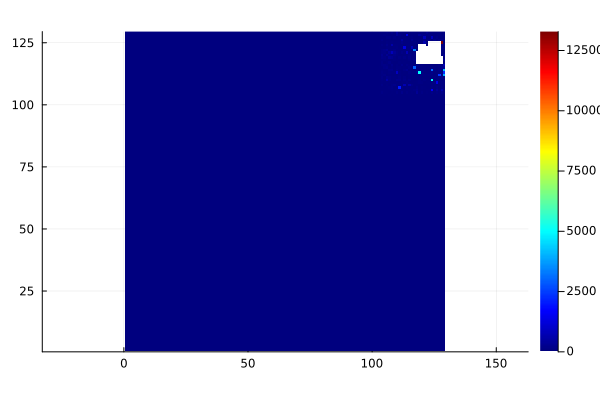

In [31]:
# display(h_fmin)
# display(h_αmin)
for t in 1:5
    for tid in 1:ncells
        collision_kernel!(tid, h_fmin, h_fplus, h_αmin, h_αplus, h_Eki, h_Eik, h_w, ν, ncells)
    end
    for tid in 1:ncells
        streaming_kernel!(tid, h_fmin, h_fplus, h_αplus, h_geom, h_w, nx, ny, ncells, h_dx, h_dy, h_opp, u0)
    end
    for tid in 1:ncells
        saving_kernel!(tid, h_ρ, h_ux, h_uy, h_fmin, h_fplus, h_dx, h_dy, ncells)
    end
end
# display(h_fmin)
display(h_αmin)
u = sqrt.(reshape(h_ux, nx, ny).^2 + reshape(h_uy, nx, ny).^2)
heatmap(u'./u0, c=:jet, aspect_ratio=:equal)

In [74]:
# kernel compilation helper
collision_gpu = @cuda threads=256 collision_kernel!(fmin, fplus, αmin, αplus, Eki, Eik, w_d, ν, ncells_d)

# main time loop
threads = 256
blocks = cld(ncells, threads)

u_list = []
ρ_list = []
@showprogress for it in 1:iterations
    @cuda threads=threads blocks=blocks collision_kernel!(fmin, fplus, αmin, αplus, Eki, Eik, w_d, ν, ncells_d)
    @cuda threads=threads blocks=blocks streaming_kernel!(fmin, fplus, αplus, geom_d, w_d, nx_d, ny_d, ncells_d, dx_d, dy_d, opp_d, u0)

    if (it % savingperiod) == 0
        @cuda threads=threads blocks=blocks saving_kernel!(ρ_d, ux_d, uy_d, fmin, fplus, dx_d, dy_d, ncells_d)

        CUDA.synchronize()

        ρ_h = Array(ρ_d)
        ux_h = Array(ux_d)
        uy_h = Array(uy_d)

        push!(ρ_list, reshape(ρ_h, nx, ny))
        push!(u_list, sqrt.(reshape(ux_h, nx, ny).^2 + reshape(uy_h, nx, ny).^2))
    end
    
    if (it % 1000) == 0
        CUDA.synchronize()
    end
end
CUDA.synchronize()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definitio

Plots.AnimatedGif("/home/matspc/SSD/FMLB/TEMP.gif")
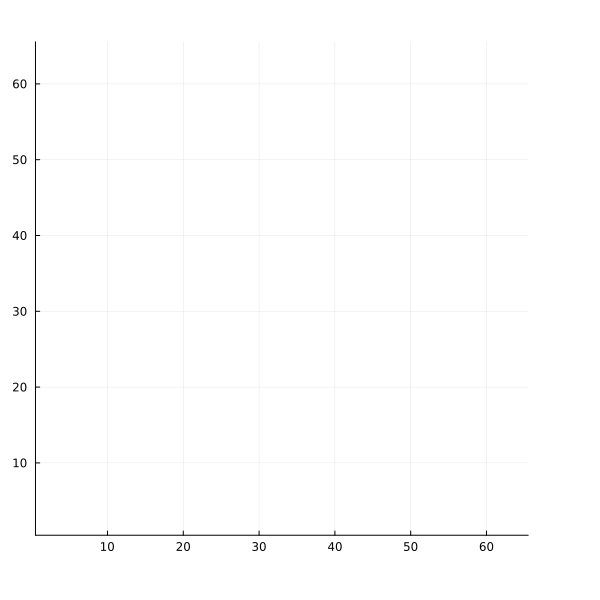

In [75]:
anim = @animate for t in 1:length(u_list)
    h = heatmap(u_list[t]'./u0, c=:jet, aspect_ratio=:equal)
    plot(h, size=(600,600))
end
gif(anim, "TEMP.gif", fps=10)

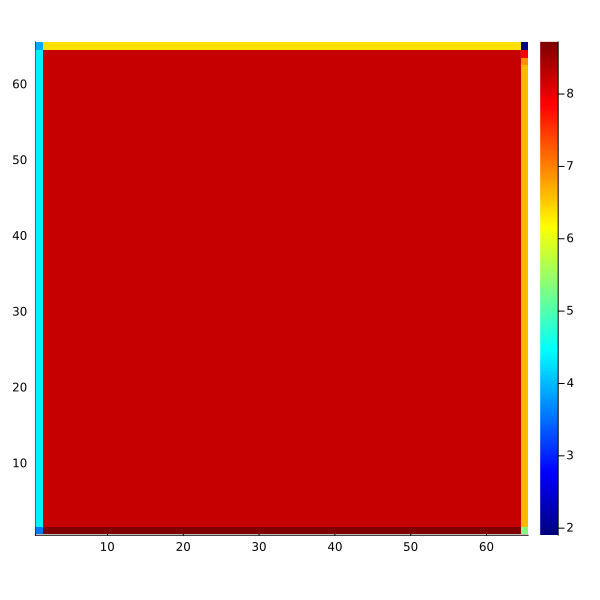

In [70]:
h = heatmap(u_list[1]'./u0, c=:jet, aspect_ratio=:equal)
plot(h, size=(600,600))

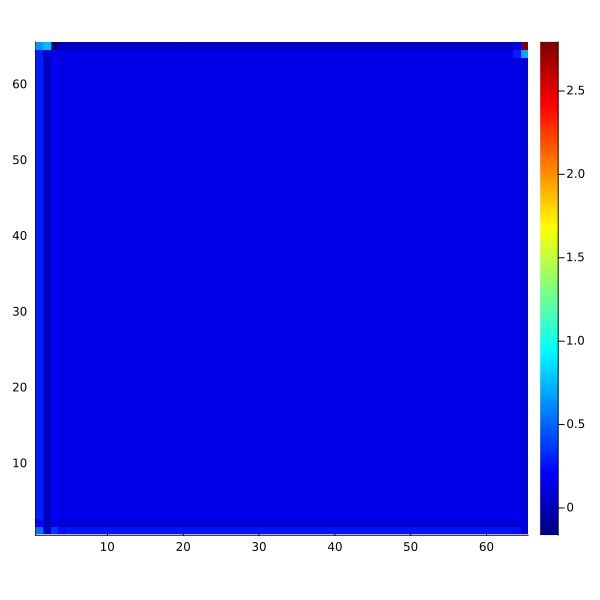

In [69]:
h = heatmap(ρ_list[5]', c=:jet, aspect_ratio=:equal)
plot(h, size=(600,600))

In [125]:
dx = h_dx
dy = h_dy
Ek(i) = [1, dx[i], 3dx[i]*dy[i], 3dx[i]^2-1, dy[i], 3dy[i]^2-1, (3dx[i]^2-1)*(3dy[i]^2-1)/2, dy[i]*(3dx[i]^2-1), dx[i]*(3dy[i]^2-1)]
Eki = Float32.(Matrix([Ek(1) Ek(2) Ek(3) Ek(4) Ek(5) Ek(6) Ek(7) Ek(8) Ek(9)]))

Ei(i) = [1, 3dx[i], 3dx[i]*dy[i], (3dx[i]^2-1)/2, 3dy[i], (3dy[i]^2-1)/2, (3dx[i]^2-1)*(3dy[i]^2-1)/2, 3dy[i]*(3dx[i]^2-1)/2, 3dx[i]*(3dy[i]^2-1)/2]'
Eik = Float32.(Matrix([Ei(1); Ei(2); Ei(3); Ei(4); Ei(5); Ei(6); Ei(7); Ei(8); Ei(9);]))
;
#save("Filter_matrices.jld2", "Eki", Eki, "Eik", Eik)